In [55]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split

In [56]:
# identifying/importing txt files
yelp= pd.read_csv('yelp_labelled.txt', header= None, sep= '\t', names= ['Review', 'Sentiment'], quoting= 3)
amazon= pd.read_csv('amazon_cells_labelled.txt', header= None, sep= '\t', names= ['Review', 'Sentiment'], quoting= 3)
imdb= pd.read_csv('imdb_labelled.txt', header= None, sep= '\t', names= ['Review', 'Sentiment'], quoting= 3)

reviews= pd.concat([yelp, amazon, imdb], ignore_index= True)

In [57]:
# profiling dataframe
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     3000 non-null   object
 1   Sentiment  3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [58]:
print("shape is: ", reviews.shape)
print(reviews.Sentiment.value_counts())
print("# of Nulls: ", reviews.isnull().sum())

shape is:  (3000, 2)
Sentiment
1    1500
0    1500
Name: count, dtype: int64
# of Nulls:  Review       0
Sentiment    0
dtype: int64


In [59]:
reviews.Review

0                                Wow... Loved this place.
1                                      Crust is not good.
2               Not tasty and the texture was just nasty.
3       Stopped by during the late May bank holiday of...
4       The selection on the menu was great and so wer...
                              ...                        
2995    I just got bored watching Jessice Lange take h...
2996    Unfortunately, any virtue in this film's produ...
2997                     In a word, it is embarrassing.  
2998                                 Exceptionally bad!  
2999    All in all its an insult to one's intelligence...
Name: Review, Length: 3000, dtype: object

In [60]:
# get examples of unusual characters
def Eng_character(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
unusual = []
for index, row in reviews.iterrows():
    for l in list(row['Review']):
        for c in l:
            if Eng_character(c) == True:
                pass
            else:
                unusual.append(c)

# 15 instances of unusual/non_english characters                
unusual[:15]

['é',
 'é',
 'ê',
 'é',
 '\x96',
 'é',
 '\x85',
 '\x96',
 'é',
 'é',
 'å',
 '\x96',
 '\x97',
 '\x96',
 'é']

In [61]:
# make all words lower case, remove punctuation
reviews.Review = reviews.Review.str.lower()

reviews.Review = reviews.Review.apply(lambda x: re.sub(r'\s+[a-z]\s+', ' ', x))
reviews.Review = reviews.Review.apply(lambda x: re.sub(r'[^a-z]', ' ', x))
reviews.Review

0                                wow    loved this place 
1                                      crust is not good 
2               not tasty and the texture was just nasty 
3       stopped by during the late may bank holiday of...
4       the selection on the menu was great and so wer...
                              ...                        
2995    i just got bored watching jessice lange take h...
2996    unfortunately  any virtue in this film s produ...
2997                       in word  it is embarrassing   
2998                                 exceptionally bad   
2999    all in all its an insult to one s intelligence...
Name: Review, Length: 3000, dtype: object

In [62]:
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)
reviews.Review = reviews.Review.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
reviews.Review

0                                         wow loved place
1                                              crust good
2                                     tasty texture nasty
3       stopped late may bank holiday rick steve recom...
4                             selection menu great prices
                              ...                        
2995        got bored watching jessice lange take clothes
2996    unfortunately virtue film production work lost...
2997                                    word embarrassing
2998                                    exceptionally bad
2999             insult one intelligence huge waste money
Name: Review, Length: 3000, dtype: object

In [63]:
# lemmatize data
def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
lemmatizer= WordNetLemmatizer()
reviews.Review = \
    reviews.Review.apply(lambda x: ' '.join([lemmatizer.lemmatize(w, get_pos(w)) for w in word_tokenize(x)]))
print(reviews.Review)

0                                          wow love place
1                                              crust good
2                                     tasty texture nasty
3       stop late may bank holiday rick steve recommen...
4                              selection menu great price
                              ...                        
2995            get bore watch jessice lange take clothes
2996    unfortunately virtue film production work lose...
2997                                       word embarrass
2998                                    exceptionally bad
2999             insult one intelligence huge waste money
Name: Review, Length: 3000, dtype: object


In [64]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews['Review'])

word_list=tokenizer.word_index
print('Vocabulary size: ', len(word_list) + 1)
list(word_list.items())[:10]

Vocabulary size:  4174


[('good', 1),
 ('great', 2),
 ('movie', 3),
 ('film', 4),
 ('phone', 5),
 ('bad', 6),
 ('one', 7),
 ('well', 8),
 ('work', 9),
 ('like', 10)]

In [65]:
# get embedding length
vocab_size = len(word_list)+1
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
max_sequence_embedding

8

In [66]:
# get max review character length
review_len = []
for char in reviews.Review:
    review_len.append(len(char.split(' ')))

# print longest review to see if it matches up
print(max(reviews['Review'], key=len))

review_longest = np.max(review_len)
review_longest

masterful piece film make many theme simmer occasionally boil wart study poet bohemian self indulgent wartime year span aerial bombardment london outward tranquillity welsh coastal retreat borderline friendship lust love dedication art experience versus practical concern jealousy rivalry cowardice egotism versus heroism self sacrifice


44

In [67]:
mean_sequence_length = int(round(np.mean(review_len), 0))
print('Mean sequence length: ' + str(mean_sequence_length))

Mean sequence length: 6


In [68]:
tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(reviews.Review)
encoded = tokenizer.texts_to_sequences(reviews.Review)
padded = pad_sequences(encoded, maxlen= review_longest)

In [69]:
# look at two random reviews
padded[100:102]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  169,  170,  122,  366,
          20,  753, 1282, 1928, 1283,  621,  537,  225,  130, 1283,   12],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1,   40,  451,  367,  315, 1929, 1284,   28]])

In [70]:
# save these ease of access later in script
vocab_size = 4174
embedding = 8
max_len = 44

In [71]:
# split into train and testing data
X_train, X_test, y_train, y_test = train_test_split(padded, reviews.Sentiment, test_size = 0.2, random_state=7)

train_shape = X_train.shape[0]
print("Input shape will be: ", train_shape)

Input shape will be:  2400


In [72]:
# save out files
pd.DataFrame(X_train).to_csv('review_training.csv')
pd.DataFrame(X_test).to_csv('review_test.csv')
pd.DataFrame(y_train).to_csv('label_training.csv')
pd.DataFrame(y_test).to_csv('label_test.csv')

In [91]:
model = Sequential()
model.add(Input(shape= (train_shape, )))
model.add(Embedding(vocab_size, embedding, input_length=max_len))
model.add(LSTM(32, dropout= 0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss= 'binary_crossentropy', optimizer= Adam(learning_rate= 0.0001), metrics= ['accuracy'])  
print(model.summary()) 

early_stopping= EarlyStopping(patience= 2)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 2400, 8)             │          33,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,571 (154.57 KB)

 Trainable params: 39,571 (154.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [92]:
history = model.fit(X_train, y_train, epochs= 20, validation_data= (X_test, y_test), callbacks= [early_stopping])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4922 - loss: 0.6931 - val_accuracy: 0.5833 - val_loss: 0.6929
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5575 - loss: 0.6927 - val_accuracy: 0.5750 - val_loss: 0.6923
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5696 - loss: 0.6923 - val_accuracy: 0.6400 - val_loss: 0.6913
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6299 - loss: 0.6905 - val_accuracy: 0.6650 - val_loss: 0.6899
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6993 - loss: 0.6882 - val_accuracy: 0.7017 - val_loss: 0.6873
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7217 - loss: 0.6838 - val_accuracy: 0.7000 - val_loss: 0.6826
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7002 - loss: 0.6774 - val_accuracy: 0.7033 - val_loss: 0.6751
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7570 - loss: 0.6639 - val_accuracy: 0.7350 - v

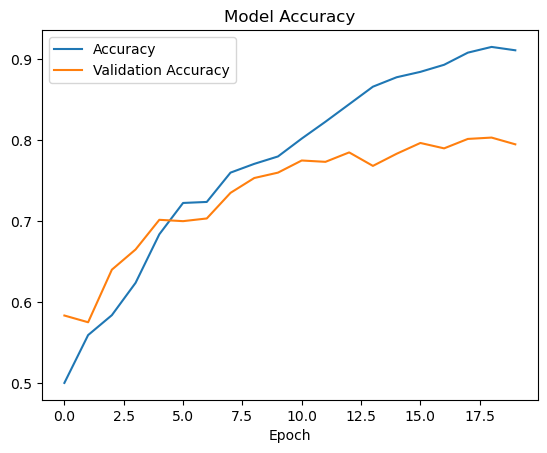

In [93]:
# model accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

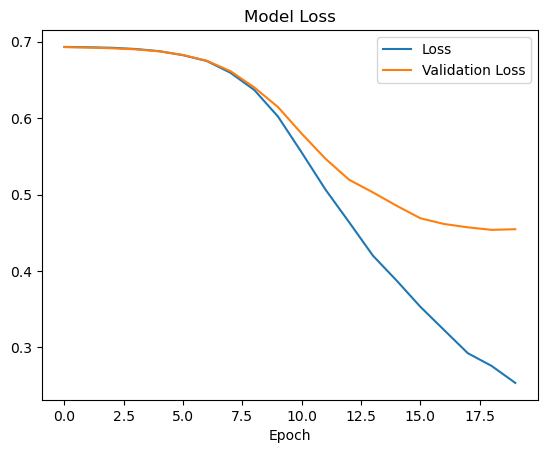

In [94]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [95]:
model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8087 - loss: 0.4429


[0.4546377956867218, 0.7950000166893005]

In [96]:
model.save('sentiment_analysis.keras')

In [97]:
#Function to run a prediction on a given text input
def predict_sentiment(text):
    tw= tokenizer.texts_to_sequences([text])
    tw= pad_sequences(tw)
    prediction= int(model.predict(tw).round().item())
    print("Predicted label: ", prediction)

In [104]:
test_sentence1 = "I would recommend it to others."
predict_sentiment(test_sentence1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted label:  1


In [103]:
test_sentence2 = "I dislike this phone"
predict_sentiment(test_sentence2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted label:  0
